# Dissecting racial bias in a medical risk score algorithm

ML Failures lab: Dissecting Racial Bias by Nick Merrill, Inderpal Kaur, Samuel Greenberg is licensed under CC BY-NC-SA 4.0. To view a copy of this license, visit https://creativecommons.org/licenses/by-nc-sa/4.0


# Learning outcomes

- Apply statistical and visualization methods to uncover sources of racial bias in a real-world algorithm.
- Discuss and evaluate how algorithms are situated in real world contexts; how they are deemed accurate, relevant or fair, and by whom.
- Discuss and evaluate how algorithms trained on past data respond (or fail to respond) to a dynamic world.

# Lecture outline

- What is health risk?
  - Who needs a health risk score?
  - Who uses health risk scores, and why?
  - Example of use
- **Discussion questions**:
  - If you had to evaluate health risk, what sorts of data would you use?
- Assumptions in health risk scores
  - Predicting the future from past data
  - A dynamic world (changes in race, health, urbanization).
  - Epistemic risks (under-reporting of medical needs, unequal access to care).
- **Discussion questions**:
  - What would it mean for a healthcare score to be "fair" or "unfair"?
  - What kinds of inputs might a "fair" algorithm have?
  - What inputs might cause an algorithm to produce "unfair" outcomes?
- The health risk index
  - Cost as a proxy of health need
  - Explain how proxy was evaluated for bias
- **Discussion questions**
  - How does the notion of risk score reflect on health as a concept? How does this score have us understand health as a concept, and/or the role of health care?
- Design vs use.
  - Who builds the health score?
  - Who uses health scores?
- **Discussion questions**
  - Who gets to produce health scores? What is their perspective on the health score, and how might their perspective differ from those who use the health scores to make decisions? How might they differ from the perspectives of patients? Why do these differences in perspective matter?

# Package Requirements

- [Pandas](https://pandas.pydata.org) and [NumPy](https://numpy.org) for data exploration and manipulation
- [Matplotlib](https://matplotlib.org)/[Seaborn](https://seaborn.pydata.org/index.html) for data visualization
- [Statsmodels](https://www.statsmodels.org/stable/index.html) for creating and fitting statistical models

# Lab

This lab is based off of [Dissecting racial bias in an algorithm used to manage the health of populations](https://science.sciencemag.org/content/366/6464/447) by Ziad Obermeyer et al (2019).

## Background

To effectively manage patients, health systems often need to estimate particular
patients' health risks. Using quantitative measures, or "risk scores,"
healthcare providers can prioritize patients and allocate resources to patients
who need them most.

In this lab, we examine an algorithm widely-used in industry to establish quantitative risk scores for patients. This algorithm uses *medical cost* (i.e., the amount a patient spends on medical care) as a proxy for risk. Through analysis of this data, we will discover how this algorithm embeds a bias against Black patients, undervaluing their medical risk relative to White patients. Crucially, this bias is not immediately visible when comparing medical costs across White and Black pateints.

The key insight of Obermeyer et al's work is that bias frequently slips into algorithmic systems unnoticed, particularly when sensitive characteristics (such as race) are ommitted or backgrounded in the data science process. In this case, bias in algorithms affects people's lives very concretely: the bias in the algorithm described here would make it more difficult for Black patients to recieve the care they need.

In this lab, we will learn how to uncover bias in algorithms, using the medical risk score example from Obermeyer et al's paper.

In [ ]:
# import statements
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker
from statsmodels.nonparametric.smoothers_lowess import lowess
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#utility function
def convert_to_percentile(df, col_name):
    """Convert column to percentile.

    Parameters
    ----------
    df : pd.DataFrame
        Data dataframe.
    col_name : str
        Name of column in df to convert to percentile.

    Returns
    -------
    pd.Series
        Column converted to percentile from 1 to 100

    """
    return pd.qcut(df[col_name].rank(method='first'), 100,
                   labels=range(1, 101))

## Medical cost and risk

To help hospitals and insurance companies identify patients who should qualify for “high-risk care management” programs, the algorithm assigns each patient a risk score. It predicts a patient’s total medical expenditure based on data from insurance claims (age, sex, diagnosis codes, etc.) and uses this variable as a proxy for health care needs.  Patient risk scores are then generated as functions of their predicted expenditures.

If the model is calibrated across race in terms of risk score and expenditure, Black and White patients with a given risk score should have similar total medical expenditures, on average.

To see if this is true, we will generate a graph that shows the mean total medical expenditure by race given a risk score percentile.



In [ ]:
#first, let's load the data we will need
data = pd.read_csv('data_new.csv')

NameError: ignored

In [ ]:
#add a column of risk percentiles to the dataframe called 'risk_percentile'
risk_percentile = convert_to_percentile(data, "risk_score_t")
data["risk_percentile"] = risk_percentile
data.head()

,risk_score_t,program_enrolled_t,cost_t,cost_avoidable_t,bps_mean_t,ghba1c_mean_t,hct_mean_t,cre_mean_t,ldl_mean_t,race,dem_female,dem_age_band_18-24_tm1,dem_age_band_25-34_tm1,dem_age_band_35-44_tm1,dem_age_band_45-54_tm1,dem_age_band_55-64_tm1,dem_age_band_65-74_tm1,dem_age_band_75+_tm1,alcohol_elixhauser_tm1,anemia_elixhauser_tm1,arrhythmia_elixhauser_tm1,arthritis_elixhauser_tm1,bloodlossanemia_elixhauser_tm1,coagulopathy_elixhauser_tm1,compdiabetes_elixhauser_tm1,depression_elixhauser_tm1,drugabuse_elixhauser_tm1,electrolytes_elixhauser_tm1,hypertension_elixhauser_tm1,hypothyroid_elixhauser_tm1,liver_elixhauser_tm1,neurodegen_elixhauser_tm1,obesity_elixhauser_tm1,paralysis_elixhauser_tm1,psychosis_elixhauser_tm1,pulmcirc_elixhauser_tm1,pvd_elixhauser_tm1,renal_elixhauser_tm1,uncompdiabetes_elixhauser_tm1,valvulardz_elixhauser_tm1,...,hct_max-normal_tm1,ldl_min-low_tm1,ldl_min-high_tm1,ldl_min-normal_tm1,ldl-mean-low_tm1,ldl-mean-high_tm1,ldl-mean-normal_tm1,ldl_max-low_tm1,ldl_max-high_tm1,ldl_max-normal_tm1,nt_bnp_min-low_tm1,nt_bnp_min-high_tm1,nt_bnp_min-normal_tm1,nt_bnp_mean-low_tm1,nt_bnp_mean-high_tm1,nt_bnp_mean-normal_tm1,nt_bnp_max-low_tm1,nt_bnp_max-high_tm1,nt_bnp_max-normal_tm1,sodium_min-low_tm1,sodium_min-high_tm1,sodium_min-normal_tm1,sodium_mean-low_tm1,sodium_mean-high_tm1,sodium_mean-normal_tm1,sodium_max-low_tm1,sodium_max-high_tm1,sodium_max-normal_tm1,trig_min-low_tm1,trig_min-high_tm1,trig_min-normal_tm1,trig_mean-low_tm1,trig_mean-high_tm1,trig_mean-normal_tm1,trig_max-low_tm1,trig_max-high_tm1,trig_max-normal_tm1,gagne_sum_tm1,gagne_sum_t,risk_percentile
0,1.987430,0,1200.0,0.0,NaN,5.4,NaN,1.110000,194.0,white,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36
1,7.677934,0,2600.0,0.0,119.0,5.5,40.4,0.860000,93.0,white,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,4,3,86
2,0.407678,0,500.0,0.0,NaN,NaN,NaN,NaN,NaN,white,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
3,0.798369,0,1300.0,0.0,117.0,NaN,NaN,NaN,NaN,white,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11
4,17.513165,0,1100.0,0.0,116.0,NaN,34.1,1.303333,53.0,white,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,98


In [ ]:
#create dataframe with the average total medical expenditure for each race at each risk percentile
group_cost = data.groupby(["risk_percentile", "race"])[["cost_t"]].mean().reset_index()
group_cost.head()

,risk_percentile,race,cost_t
0,1,black,1033.333333
1,1,white,905.176471
2,2,black,1365.079365
3,2,white,2959.764706
4,3,black,1271.428571


In [ ]:
#divide group_cost into two dataframes based on race
b_cost = group_cost[group_cost['race'] == 'black']
w_cost = group_cost[group_cost['race'] == 'white']

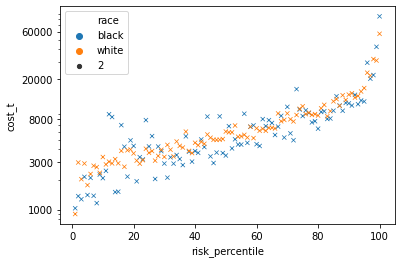

In [ ]:
#scatterplot of risk percentile against cost, splitting on race
ax = sns.scatterplot(x = "risk_percentile", y = "cost_t", data = group_cost, hue = "race", marker = "x", size = 2, legend = "full")
plt.yscale('log')
ax.set_yticks([1000, 3000, 8000, 20000, 60000])
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.legend;

In [ ]:
#fit a LOWESS (Locally Weighted Scatterplot Smoothing) model to the scatterplot above for each race
risk_percentile_array_b = np.array(b_cost['risk_percentile'])
risk_percentile_array_w = np.array(w_cost['risk_percentile'])
b_cost_array = np.array(b_cost['cost_t'])
w_cost_array = np.array(w_cost['cost_t'])
b_cost_lowess = lowess(b_cost_array, risk_percentile_array_b, it=35, frac=0.2, delta=2)
w_cost_lowess = lowess(w_cost_array, risk_percentile_array_w, it=35, frac=0.2, delta=2)

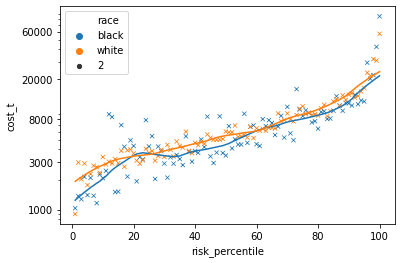

In [ ]:
#plot the model on the scatterplot
ax = sns.scatterplot(x = "risk_percentile", y = "cost_t", data = group_cost, hue = "race", marker = "x", size = 2, legend = "full")
plt.yscale('log')
plt.plot(risk_percentile_array_b, b_cost_lowess[:, 1])
plt.plot(risk_percentile_array_w, w_cost_lowess[:, 1])
ax.set_yticks([1000, 3000, 8000, 20000, 60000])
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

What do you notice about the relationship between medical expenditure and risk score by race?

Can you conclude from this data that the model is fair or not fair?

**Example answer**: *A Black patient with a particular risk score appears to spend about the same amount on medical expenses than a white patient with the same risk score. If we assume that cost is a proxy for medical need, this model may be fair. However, we cannot assume that this assumption holds. For example, Black and White patients may have unequal access to care for financial, insurance or other structural reasons, which would make this risk score undervalue the true medical risk of Black patients.* 

## Chronic illness and risk

Next, we will check to see if the model is calibrated across groups in terms of risk score and chronic illness. Equivalently, for a given risk score do Black and White patients have the same level of health? 

If cost is a good proxy for need, we would expect this graph to be as balanced as the prior graph.  In other words, health care cost should not vary conditional on health between groups.

Generate a graph that shows the mean number of chronic illnesses by race given a risk score percentile.



In [ ]:
# create dataframe with the average number of chronic illnesses for each race at each risk percentile
grouped_by_race = data.groupby(["risk_percentile", "race"])[["gagne_sum_t"]].mean().reset_index()
grouped_by_race.head()

,risk_percentile,race,gagne_sum_t
0,1,black,0.079365
1,1,white,0.044706
2,2,black,0.206349
3,2,white,0.134118
4,3,black,0.317460


In [ ]:
# divide the grouped dataframe into two dataframes based on race
black_patients = grouped_by_race[grouped_by_race['race'] == 'black']
white_patients = grouped_by_race[grouped_by_race['race'] == 'white']

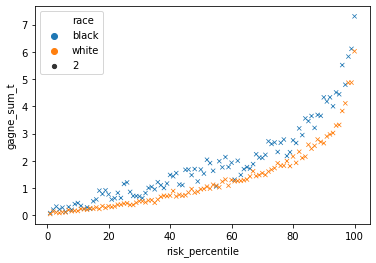

In [ ]:
# create a scatterplot of risk percentile against average number of chronic ilnesses, splitting on race
sns.scatterplot(x="risk_percentile", y="gagne_sum_t", data=grouped_by_race, hue="race", marker="x", size=2, legend="full")

In [ ]:
#fit a Generalized Linear Model (GLM) to the scatterplot above for each race
X_b = sm.add_constant(np.array(black_patients["risk_percentile"]))
model_b = sm.GLM(black_patients["gagne_sum_t"], X_b, family=sm.families.Gaussian(link=sm.families.links.log))
model_b_results = model_b.fit()

X_w = sm.add_constant(np.array(white_patients["risk_percentile"]))
model_w = sm.GLM(white_patients["gagne_sum_t"], X_w, family=sm.families.Gaussian(link=sm.families.links.log))
model_w_results = model_w.fit()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  


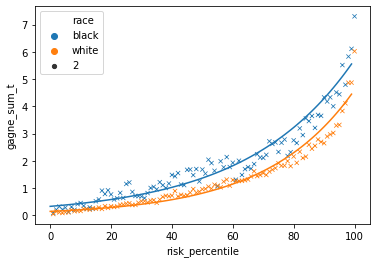

In [ ]:
# plot the model on the scatterplot
sns.scatterplot(x="risk_percentile", y="gagne_sum_t", data=grouped_by_race, hue="race", marker="x", size=2, legend="full")
plt.plot(black_patients["risk_percentile"], model_b_results.predict())
plt.plot(white_patients["risk_percentile"], model_w_results.predict())
plt.legend();

What do you notice about the relationship between chronic illness and risk score by race?

Can you conclude from this data that the model is fair or not fair?

**Example answer**: *There is a difference in the number of chronic illnesses by race. Since a Black patient tends to have more markers of chronic illness than a White patient with the same risk score, this model does not appear to be fair.*

## Interactions between cost and illness

Our work above shows us that a Black patient and a White patient with the same risk score tend to spend the same amount on medical care on average, yet the Black patient tends to have more chronic illnesses.

To understand this interaction, generate a graph that shows the mean total medical expenditure by race, given the number of chronic illnesses.

In [ ]:
#add a column of illness percentiles to the dataframe called 'illness_percentile'
illness_percentile = convert_to_percentile(data, "gagne_sum_t")
data['illness_percentile'] = illness_percentile
data.head()

,risk_score_t,program_enrolled_t,cost_t,cost_avoidable_t,bps_mean_t,ghba1c_mean_t,hct_mean_t,cre_mean_t,ldl_mean_t,race,dem_female,dem_age_band_18-24_tm1,dem_age_band_25-34_tm1,dem_age_band_35-44_tm1,dem_age_band_45-54_tm1,dem_age_band_55-64_tm1,dem_age_band_65-74_tm1,dem_age_band_75+_tm1,alcohol_elixhauser_tm1,anemia_elixhauser_tm1,arrhythmia_elixhauser_tm1,arthritis_elixhauser_tm1,bloodlossanemia_elixhauser_tm1,coagulopathy_elixhauser_tm1,compdiabetes_elixhauser_tm1,depression_elixhauser_tm1,drugabuse_elixhauser_tm1,electrolytes_elixhauser_tm1,hypertension_elixhauser_tm1,hypothyroid_elixhauser_tm1,liver_elixhauser_tm1,neurodegen_elixhauser_tm1,obesity_elixhauser_tm1,paralysis_elixhauser_tm1,psychosis_elixhauser_tm1,pulmcirc_elixhauser_tm1,pvd_elixhauser_tm1,renal_elixhauser_tm1,uncompdiabetes_elixhauser_tm1,valvulardz_elixhauser_tm1,...,ldl_min-low_tm1,ldl_min-high_tm1,ldl_min-normal_tm1,ldl-mean-low_tm1,ldl-mean-high_tm1,ldl-mean-normal_tm1,ldl_max-low_tm1,ldl_max-high_tm1,ldl_max-normal_tm1,nt_bnp_min-low_tm1,nt_bnp_min-high_tm1,nt_bnp_min-normal_tm1,nt_bnp_mean-low_tm1,nt_bnp_mean-high_tm1,nt_bnp_mean-normal_tm1,nt_bnp_max-low_tm1,nt_bnp_max-high_tm1,nt_bnp_max-normal_tm1,sodium_min-low_tm1,sodium_min-high_tm1,sodium_min-normal_tm1,sodium_mean-low_tm1,sodium_mean-high_tm1,sodium_mean-normal_tm1,sodium_max-low_tm1,sodium_max-high_tm1,sodium_max-normal_tm1,trig_min-low_tm1,trig_min-high_tm1,trig_min-normal_tm1,trig_mean-low_tm1,trig_mean-high_tm1,trig_mean-normal_tm1,trig_max-low_tm1,trig_max-high_tm1,trig_max-normal_tm1,gagne_sum_tm1,gagne_sum_t,risk_percentile,illness_percentile
0,1.987430,0,1200.0,0.0,NaN,5.4,NaN,1.110000,194.0,white,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36,1
1,7.677934,0,2600.0,0.0,119.0,5.5,40.4,0.860000,93.0,white,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,4,3,86,82
2,0.407678,0,500.0,0.0,NaN,NaN,NaN,NaN,NaN,white,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,1
3,0.798369,0,1300.0,0.0,117.0,NaN,NaN,NaN,NaN,white,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,1
4,17.513165,0,1100.0,0.0,116.0,NaN,34.1,1.303333,53.0,white,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,98,46


In [ ]:
#create dataframe with the average total medical expenditure for each race at each illness percentile
illnesses = data.groupby(["illness_percentile", "race"])[["cost_t"]].mean().reset_index()
illnesses.head()

,illness_percentile,race,cost_t
0,1,black,3825.000000
1,1,white,3883.991228
2,2,black,2955.172414
3,2,white,3705.446623
4,3,black,2985.714286


In [ ]:
#divide illnesses into two dataframes based on race
illness_b = illnesses[illnesses['race'] == 'black']
illness_w = illnesses[illnesses['race'] == 'white']

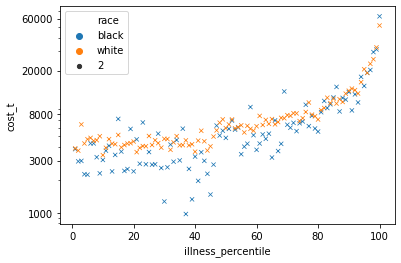

In [ ]:
#scatterplot of illness percentile against cost, splitting on race
ax = sns.scatterplot(x = "illness_percentile", y = "cost_t", data = illnesses, hue = "race", marker = "x", size = 2, legend = "full")
plt.yscale('log')
ax.set_yticks([1000, 3000, 8000, 20000, 60000])
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

In [ ]:
#fit a LOWESS (Locally Weighted Scatterplot Smoothing) model to the scatterplot above for each race
illness_percentile_array_b = np.array(illness_b['illness_percentile'])
illness_percentile_array_w = np.array(illness_w['illness_percentile'])
illness_cost_b = np.array(illness_b['cost_t'])
illness_cost_w = np.array(illness_w['cost_t'])
b_illness_lowess = lowess(illness_cost_b, illness_percentile_array_b, it=35, frac=0.3, delta=2)
w_illness_lowess = lowess(illness_cost_w, illness_percentile_array_w, it=35, frac=0.3, delta=2)

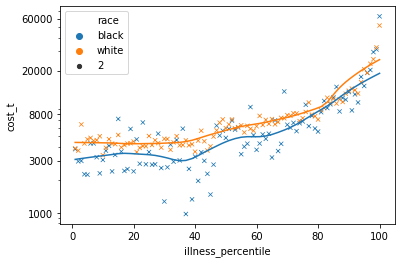

In [ ]:
#plot the model on the scatterplot
ax = sns.scatterplot(x = "illness_percentile", y = "cost_t", data = illnesses, hue = "race", marker = "x", size = 2, legend = "full")
plt.yscale('log')
plt.plot(illness_percentile_array_b, b_illness_lowess[:, 1])
plt.plot(illness_percentile_array_w, w_illness_lowess[:, 1])
ax.set_yticks([1000, 3000, 8000, 20000, 60000])
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

What can you conclude about the relationship between cost and chronic illness? Why might this relationship exist? What are consequences for the risk score model?

**Example answer**:

*Given a Black patient and a White patient with the same number of chronic illnesses, the Black patient tends to spend less. This relationship may exist due to unequal access to medical care, perhaps due to limited financial resources among Black patients, worse access to medical facilities, and/or unequal access to employment-related medical benefits such as health insurance. Another factor might be bias in the medical system itself (e.g., doctors and nurses paying less attention to Black patients compared to White patients).*

*For our model, this relationship demonstrates a racial bias in the relationship between cost and chronic illness. In effect, it means the risk score model will systematically undervalue the medical risk of Black patients.*


## Conclusions and takeaways

Even systems that appear balanced across racial groups at first glance may belie underlying biases in the datasets. Thus, seemingly unbiased predictors can in fact be highly correlated with a biasing variable such as race, gender, income or other relational characteristics.

In this example, bias emerged from using an indicator of need (cost) that was itself influenced by race. Biased estimation of need between races resulted.

To better understand the ways in which race influences health care cost, here is a segment from Obermeyer et al’s paper:
 
>The literature broadly suggests two main potential channels. **First, poor patients face substantial barriers to accessing health care, even when enrolled in insurance plans.** Although the population we study is entirely insured, there are many other mechanisms by which poverty can lead to disparities in use of health care: geography and differential access to transportation, competing demands from jobs or child care, or knowledge of reasons to seek care (1-3). To the extent that race and socioeconomic status are correlated, these factors will differentially affect Black patients. **Second, race could affect costs directly via several channels: direct (“taste-based”) discrimination, changes to the doctor–patient relationship, or others.** A recent trial randomly assigned Black patients to a Black or White primary care provider and found significantly higher uptake of recommended preventive care when the provider was Black (4). This is perhaps the most rigorous demonstration of this effect, and it fits with a larger literature on potential mechanisms by which race can affect health care directly. For example, it has long been documented that Black patients have reduced trust in the health care system (5), a fact that some studies trace to the revelations of the Tuskegee study and other adverse experiences (6). A substantial literature in psychology has documented physicians’ differential perceptions of Black patients, in terms of intelligence, affiliation (7), or pain tolerance (8). **Thus, whether it is communication, trust, or bias, something about the interactions of Black patients with the health care system itself leads to reduced use of health care. The collective effect of these many channels is to lower health spending substantially for Black patients, conditional on need—a finding that has been appreciated for at least two decades (9).**

## Reflection Questions

Here are two final open-ended questions for you to answer.

1. How could we use the data we have to create new proxies for health needs that may be less biased than medical costs?

**Example answer**: *The authors of the paper created an index variable that combined health prediction with cost prediction which  resulted in an 84% reduction in bias.*

2. What are other applications of prediction algorithms where this type of bias may also arise?

**Example Answer**: *Recidivism prediction algorithms, credit score algorithms, etc.*

## References

1. K. Fiscella, P. Franks, M. R. Gold, C. M. Clancy, JAMA 283, 2579–2584 (2000).
2. N. E. Adler, K. Newman, Health Aff. 21, 60–76 (2002).
3. N. E. Adler, W. T. Boyce, M. A. Chesney, S. Folkman, S. L. Syme, JAMA 269, 3140–3145 (1993).
4. M. Alsan, O. Garrick, G. C. Graziani, “Does diversity matter for health? Experimental evidence from Oakland” (National Bureau of Economic Research, 2018).
5. K. Armstrong, K. L. Ravenell, S. McMurphy, M. Putt, Am. J. Public Health 97, 1283–1289 (2007).
6. M. Alsan, M. Wanamaker, Q. J. Econ. 133, 407–455 (2018).
7. M. van Ryn, J. Burke, Soc. Sci. Med. 50, 813–828 (2000).
8. K. M. Hoffman, S. Trawalter, J. R. Axt, M. N. Oliver, Proc. Natl. Acad. Sci. U.S.A. 113, 4296–4301 (2016).
9. J. J. Escarce, F. W. Puffer, in Racial and Ethnic Differences in the Health of Older Americans (National Academies Press, 1997), chap. 6; www.ncbi.nlm.nih.gov/books/ NBK109841/.

# Feedback

**Instructors**: Please [provide feedback](https://docs.google.com/forms/d/1UuUVBBMTU_2aMvzsGnTR_4i1w3F6tLaaqdIr7dQrgSI/edit?ts=5efa771b&dods) to help improve this lab.

**Students**: Please [provide feedback](https://docs.google.com/forms/d/1jI8oXRkqD1l1ARuZR1y9W_qkOystPr-YEyywNDez46M/edit?ts=5efa772a&dods) to help improve this lab.
